Mean Squared Error: 64537.27848145737


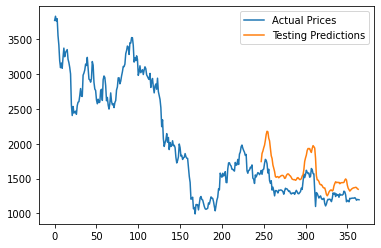

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Assuming eth_data is your DataFrame with Ethereum price data 

# Assuming 'Close' is the column containing closing prices
prices = eth_data['Close'].values.astype(float)
prices = prices.reshape(-1, 1)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Split the dataset into training and testing sets
train_size = int(len(prices_scaled) * 0.67)
test_size = len(prices_scaled) - train_size
train, test = prices_scaled[0:train_size, :], prices_scaled[train_size:len(prices_scaled), :]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=look_back, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Instantiate the model, define loss function and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
for i in range(epochs):
    for seq, labels in zip(trainX, trainY):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(torch.FloatTensor(seq))
        single_loss = loss_function(y_pred, torch.FloatTensor([labels]))
        single_loss.backward()
        optimizer.step()

# Test the model
model.eval()
testPredictions = []
for seq in testX:
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        testPredictions.append(model(torch.FloatTensor(seq)).item())

# Invert predictions
testPredictions = scaler.inverse_transform(np.array(testPredictions).reshape(-1, 1))
testY_original = scaler.inverse_transform(testY.reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(testY_original, testPredictions)
print(f'Mean Squared Error: {mse}')

# Plot the baseline and predictions
plt.plot(scaler.inverse_transform(prices_scaled), label='Actual Prices')
plt.plot(train_size + look_back + np.arange(len(testPredictions)), testPredictions, label='Testing Predictions')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
Linear Regression Mean Squared Error: 12898.744721151574
SVM Mean Squared Error: 766846.9722699897
FFNN Mean Squared Error: 1712.5694941198617
LSTM Mean Squared Error: 37089.60947865588


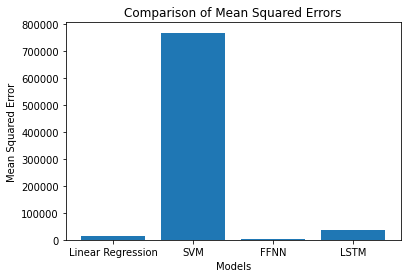

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Function to collect data from Yahoo Finance
def get_historical_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

# Function to perform linear regression
def perform_linear_regression(data):
    y = data['Close']
    y = y.shift(-1).dropna()
    X = data[['Close', 'Open', 'High', 'Low', 'Volume']].iloc[:-1].dropna()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    predictions_lr = model_lr.predict(X_test)
    mse_lr = mean_squared_error(y_test, predictions_lr)
    print(f'Linear Regression Mean Squared Error: {mse_lr}')

    return predictions_lr, mse_lr

# Function to perform support vector machine regression
def perform_svm_regression(data):
    X = data[['Close', 'Open', 'High', 'Low', 'Volume']].values
    y = data['Close'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_rbf.fit(X_train, y_train)
    predictions_svm = svr_rbf.predict(X_test)
    mse_svm = mean_squared_error(y_test, predictions_svm)
    print(f'SVM Mean Squared Error: {mse_svm}')

    return predictions_svm, mse_svm

# Function to perform feedforward neural network regression
def perform_ffnn_regression(X_train, X_test, y_train, y_test):
    scaler_ffnn = MinMaxScaler()
    X_train_ffnn = scaler_ffnn.fit_transform(X_train)
    X_test_ffnn = scaler_ffnn.transform(X_test)
    y_train_ffnn = scaler_ffnn.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
    y_test_ffnn = scaler_ffnn.transform(y_test.reshape(-1, 1)).reshape(-1)

    model_ffnn = Sequential()
    model_ffnn.add(Dense(64, input_dim=X_train_ffnn.shape[1], activation='relu'))
    model_ffnn.add(Dense(32, activation='relu'))
    model_ffnn.add(Dense(1, activation='linear'))
    model_ffnn.compile(optimizer='adam', loss='mean_squared_error')
    history_ffnn = model_ffnn.fit(X_train_ffnn, y_train_ffnn, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    y_pred_ffnn = model_ffnn.predict(X_test_ffnn)
    y_pred_ffnn = scaler_ffnn.inverse_transform(y_pred_ffnn)
    y_test_ffnn = scaler_ffnn.inverse_transform(y_test_ffnn.reshape(-1, 1)).reshape(-1)
    mse_ffnn = mean_squared_error(y_test_ffnn, y_pred_ffnn)
    print(f'FFNN Mean Squared Error: {mse_ffnn}')

    return y_pred_ffnn, mse_ffnn

# Function to perform LSTM regression
def perform_lstm_regression(prices_scaled):
    train_size = int(len(prices_scaled) * 0.67)
    test_size = len(prices_scaled) - train_size
    train, test = prices_scaled[0:train_size, :], prices_scaled[train_size:len(prices_scaled), :]

    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    look_back = 3
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    class LSTM(nn.Module):
        def __init__(self, input_size=look_back, hidden_layer_size=100, output_size=1):
            super().__init__()
            self.hidden_layer_size = hidden_layer_size
            self.lstm = nn.LSTM(input_size, hidden_layer_size)
            self.linear = nn.Linear(hidden_layer_size, output_size)
            self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                                torch.zeros(1,1,self.hidden_layer_size))

        def forward(self, input_seq):
            lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
            predictions = self.linear(lstm_out.view(len(input_seq), -1))
            return predictions[-1]

    model = LSTM()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 50
    for i in range(epochs):
        for seq, labels in zip(trainX, trainY):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(torch.FloatTensor(seq))
            single_loss = loss_function(y_pred, torch.FloatTensor([labels]))
            single_loss.backward()
            optimizer.step()

    model.eval()
    testPredictions = []
    for seq in testX:
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            testPredictions.append(model(torch.FloatTensor(seq)).item())

    testPredictions = scaler.inverse_transform(np.array(testPredictions).reshape(-1, 1))
    testY_original = scaler.inverse_transform(testY.reshape(-1, 1))

    mse_lstm = mean_squared_error(testY_original, testPredictions)
    print(f'LSTM Mean Squared Error: {mse_lstm}')

    return testPredictions, mse_lstm

# Define the symbol and time period
symbol = 'ETH-USD'
start_date = '2022-01-01'
end_date = '2023-01-01'

# Download historical data
eth_data = get_historical_data(symbol, start_date, end_date)

# Feature selection for SVM, FFNN, and LR
X = eth_data[['Close', 'Open', 'High', 'Low', 'Volume']].values
y = eth_data['Close'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection for LSTM
prices = eth_data['Close'].values.astype(float)
prices = prices.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Linear Regression
predictions_lr, mse_lr = perform_linear_regression(eth_data)

# SVM
predictions_svm, mse_svm = perform_svm_regression(eth_data)

# FFNN
y_pred_ffnn, mse_ffnn = perform_ffnn_regression(X_train, X_test, y_train, y_test)

# LSTM
predictions_lstm, mse_lstm = perform_lstm_regression(prices_scaled)

# Compare losses
models = ['Linear Regression', 'SVM', 'FFNN', 'LSTM']
losses = [mse_lr, mse_svm, mse_ffnn, mse_lstm]

plt.bar(models, losses)
plt.title('Comparison of Mean Squared Errors')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.show()
